This notebook uses the hand-labeled data and SQL-derived data prepared previously. Here we develop, train, and test a gradient boosting classifier to assign a vandalism probability score using a sample of the latter data, then validate it using the hand-labeled 'ground truth.' This model is essentially a toy version of the ORES vandalism detection tool used by Wikipedia to flag potentially harmful edits.

In [712]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import p5utils
import re
import textblob
import pickle
import mwapi

I actually started with the human-labeled data.

In [4]:
with open("./labeled_ores.pkl", "rb") as f:
    labeled_ores = pickle.load(f)

In [46]:
labeled_ores = labeled_ores[labeled_ores['damaging'].notna()].reset_index()

Let's get a few additional features in the labeled data.

In [19]:
labeled_ores.loc[:, 'diff'] = labeled_ores['tosize'] - labeled_ores['fromsize']
labeled_ores.loc[:, 'added_bytes'] = labeled_ores['diff'].map(lambda x: x if x > 0 else 0)
labeled_ores.loc[:, 'deleted_bytes'] = labeled_ores['diff'].map(lambda x: -x if x < 0 else 0)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


A little function to pull four dummy variables out of our article topic columns.

In [47]:
def topic_dummies(drafttopics):
    culture = 0
    geography = 0
    hist_soc = 0
    stem = 0
    for topic in drafttopics:
        topic = topic.split('.')[0]
        if topic=="Culture":
            culture = 1
        if topic=="Geography":
            geography = 1
        if topic=="History_And_Society":
            hist_soc = 1
        if topic=="STEM":
            stem = 1
    return culture, geography, hist_soc, stem

In [48]:
cat_dummies = pd.DataFrame(labeled_ores['drafttopic'].map(topic_dummies).tolist())

In [49]:
labeled_ores[['culture', 'geography', 'hist_soc', 'stem']] = cat_dummies

Let's also merge in the average country damage probability.

In [53]:
with open('country_iso_damage.pkl', 'rb') as f:
    country_iso_damage = pickle.load(f)

In [60]:
country_iso_damage = country_iso_damage.rename({'damage_prob': 'country_damage'}, axis=1)

In [64]:
labeled_ores = pd.merge(labeled_ores,
                        country_iso_damage,
                        on='country_iso')\
                 .drop(['index', 'pct_diff'], axis=1)

And finally, the most exciting feature: the bad words count. I based my bad words lists on those used by the [revscoring tool](https://github.com/wikimedia/revscoring/blob/master/revscoring/languages/english.py) (CAUTION: very rude), which ORES is built on, with a few additions of my own. I initially split the list into "very bad words" (curse words, racial slurs) and "bad words" (informal language, mentions of Wikipedia), but my model performed better when they were aggregated into one list.

In [670]:
def count_badwords(text):
    text = " ".join(text)
    text = re.sub("\{\{.*\}\}|<.*>", "", text)
    text = textblob.TextBlob(text)
    badwords_count = 0
    for word in text.words:
        if re.fullmatch(r"[A-Z]{4,}\b", word):
            badwords_count += 1
        word = word.lower()
        for badword in p5utils.badwords + p5utils.verybadwords:
            if re.fullmatch(badword, word):
                badwords_count += 1
    return badwords_count

In [673]:
labeled_ores['badwords'] = labeled_ores['additions'].map(count_badwords)

In [674]:
labeled_ores.query('damaging==True')['badwords'].mean()

6.750556792873051

In [675]:
labeled_ores.query('damaging==False')['badwords'].mean()

0.1350844277673546

In [797]:
def get_vectors(df):
    X = df[['badwords', 'fromsize', 'added_bytes', 'deleted_bytes',
                  'country_damage', 'culture', 'geography', 'hist_soc', 'stem']]
    y = df['damaging'].map(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    random_state=123,
                                                    stratify=df['damaging'])
    
    return X_train, X_test, y_train, y_test

Let's build two baseline "models" that either classify everything as the majority class, or guess randomly based on the class distribution.

In [412]:
labeled_ores['damaging'].value_counts(normalize=True)

False    0.855812
True     0.144188
Name: damaging, dtype: float64

In [317]:
def informed_guess_model(X):
    np.random.seed(123)
    length = X.shape[0]
    pred = np.zeros(length)
    cutoff = int(length*0.144) # see above
    pred[:cutoff] = 1
    np.random.shuffle(pred)
    return pred

In [826]:
def print_metrics(y_true, y_pred):
    print("Accuracy score:", accuracy_score(y_true, y_pred))
    print("F1 score:", f1_score(y_true, y_pred))
    print("ROC AUC score:", roc_auc_score(y_true, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

In [832]:
X_train, X_test, y_train, y_test = get_vectors(labeled_ores)

In [833]:
y_pred = informed_guess_model(X_train)
print_metrics(y_train, y_pred)

Accuracy score: 0.7548179871520343
F1 score: 0.14869888475836432
ROC AUC score: 0.5027394941328995
Confusion matrix:
 [[2055  343]
 [ 344   60]]


In [564]:
def always_nonvandal_model(X):
    return np.zeros(X.shape[0])

In [834]:
y_pred = always_nonvandal_model(X_train)
print_metrics(y_train, y_pred)

Accuracy score: 0.8558172733761599
F1 score: 0.0
ROC AUC score: 0.5
Confusion matrix:
 [[2398    0]
 [ 404    0]]


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Some fairly unscientific model exploration. After a few dead ends it seemed like a tree ensemble model, like gradient boosting, did the best by far.

In [839]:
def fit_and_test(model):
    sm = SMOTE(sampling_strategy=0.85, random_state=123)
    X_smote, y_smote = sm.fit_resample(X_train, y_train)
    model.fit(X_smote, y_smote)
    y_pred = model.predict(X_test)
    print_metrics(y_test, y_pred)

In [840]:
lr = LogisticRegressionCV(Cs=20, cv=5, scoring='accuracy', random_state=123)
fit_and_test(lr)

Accuracy score: 0.8044871794871795
F1 score: 0.2823529411764706
ROC AUC score: 0.5808988764044942
Confusion matrix:
 [[239  28]
 [ 33  12]]


In [330]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [361]:
labeled_ores['lr_proba'] = lr.predict_proba(X)[:,1]

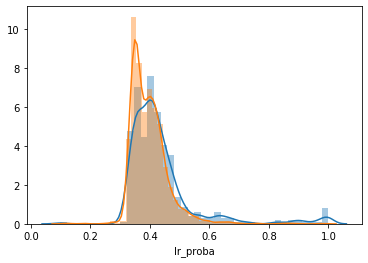

In [362]:
sns.distplot(labeled_ores.query('damaging==True')['lr_proba'])
sns.distplot(labeled_ores.query('damaging==False')['lr_proba'])

In [843]:
gb = GradientBoostingClassifier(learning_rate = 0.01, n_estimators=500)
fit_and_test(gb)

Accuracy score: 0.8589743589743589
F1 score: 0.26666666666666666
ROC AUC score: 0.5757802746566791
Confusion matrix:
 [[260   7]
 [ 37   8]]


This looks better than it should, because it's including the training data.

In [392]:
labeled_ores['gb_proba'] = gb.predict_proba(X)[:,1]

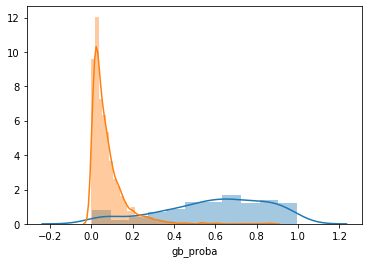

In [393]:
sns.distplot(labeled_ores.query('damaging==True')['gb_proba'])
sns.distplot(labeled_ores.query('damaging==False')['gb_proba'])

Since my human-labeled data was rather small, I decided to train on a 10,000 row sample of my massive 2019 machine-labeled data.

In [445]:
with open('changes_sample_ores.pkl', 'rb') as f:
    changes_sample = pickle.load(f)

In [449]:
changes_sample = pd.merge(changes_sample,
                        country_iso_damage,
                        on='country_iso')\
                 .drop(['pct_diff'], axis=1)

In [451]:
changes_sample.loc[:, 'added_bytes'] = changes_sample['len_diff'].map(lambda x: x if x > 0 else 0)
changes_sample.loc[:, 'deleted_bytes'] = changes_sample['len_diff'].map(lambda x: -x if x < 0 else 0)

In [453]:
changes_sample = changes_sample.rename({'rc_old_len': 'fromsize', 'rc_new_len': 'tosize'}, axis=1)

In [459]:
cat_dummies = pd.DataFrame(changes_sample['drafttopic'].map(topic_dummies).tolist())
changes_sample[['culture', 'geography', 'hist_soc', 'stem']] = cat_dummies

In [676]:
changes_sample['badwords'] = changes_sample['additions'].map(count_badwords)

In [798]:
X_train, X_test, y_train, y_test = get_vectors(changes_sample)

In [837]:
def fit_and_test_gb(learning_rate, smote_strat):
    gb = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=500, max_depth=3)
    sm = SMOTE(sampling_strategy=smote_strat, random_state=123)
    X_smote, y_smote = sm.fit_resample(X_train, y_train)
    gb.fit(X_smote, y_smote)
    y_pred = gb.predict(X_test)
    print_metrics(y_test, y_pred)
    return gb

In [810]:
gb = fit_and_test_gb(0.01, 0.95)

Accuracy score: 0.8646464646464647
F1 score: 0.3557692307692307
ROC AUC score: 0.6131826335370715
Confusion matrix:
 [[819  29]
 [105  37]]


Some hyperparameter tuning. Yes, yes, I should have done this across K folds instead of a single test set. At least I'm going to do my final testing against the human labeled data.

In [809]:
for smote in np.linspace(0.5, 1.0, 10):
    print("SMOTE strategy:", smote)
    fit_and_test_gb(0.01, smote)

SMOTE strategy: 0.3
Accuracy score: 0.8646464646464647
F1 score: 0.26373626373626374
ROC AUC score: 0.5750730799893702
Confusion matrix:
 [[832  16]
 [118  24]]
SMOTE strategy: 0.3
Accuracy score: 0.8686868686868687
F1 score: 0.28571428571428575
ROC AUC score: 0.5832945787935158
Confusion matrix:
 [[834  14]
 [116  26]]
SMOTE strategy: 0.3
Accuracy score: 0.8707070707070707
F1 score: 0.2967032967032967
ROC AUC score: 0.5874053281955885
Confusion matrix:
 [[835  13]
 [115  27]]
SMOTE strategy: 0.3
Accuracy score: 0.8666666666666667
F1 score: 0.2826086956521739
ROC AUC score: 0.5821153335104969
Confusion matrix:
 [[832  16]
 [116  26]]
SMOTE strategy: 0.3
Accuracy score: 0.8717171717171717
F1 score: 0.3280423280423281
ROC AUC score: 0.5997209673133138
Confusion matrix:
 [[832  16]
 [111  31]]
SMOTE strategy: 0.3
Accuracy score: 0.8707070707070707
F1 score: 0.32631578947368417
ROC AUC score: 0.5991313446718044
Confusion matrix:
 [[831  17]
 [111  31]]
SMOTE strategy: 0.3
Accuracy score: 0

In [808]:
for rate in np.linspace(0.005, 0.3, 10):
    print("Rate:", rate)
    fit_and_test_gb(rate, 0.75)

Rate: 0.005
Accuracy score: 0.8676767676767677
F1 score: 0.3282051282051282
ROC AUC score: 0.60029398086633
Confusion matrix:
 [[827  21]
 [110  32]]
Rate: 0.03777777777777777
Accuracy score: 0.8656565656565657
F1 score: 0.2810810810810811
ROC AUC score: 0.5815257108689875
Confusion matrix:
 [[831  17]
 [116  26]]
Rate: 0.07055555555555555
Accuracy score: 0.8686868686868687
F1 score: 0.3157894736842105
ROC AUC score: 0.5950205952697315
Confusion matrix:
 [[830  18]
 [112  30]]
Rate: 0.10333333333333333
Accuracy score: 0.8686868686868687
F1 score: 0.32291666666666663
ROC AUC score: 0.5979520993887856
Confusion matrix:
 [[829  19]
 [111  31]]
Rate: 0.1361111111111111
Accuracy score: 0.8626262626262626
F1 score: 0.2989690721649485
ROC AUC score: 0.588551355301621
Confusion matrix:
 [[825  23]
 [113  29]]
Rate: 0.16888888888888887
Accuracy score: 0.8606060606060606
F1 score: 0.28865979381443296
ROC AUC score: 0.5844406058995482
Confusion matrix:
 [[824  24]
 [114  28]]
Rate: 0.201666666666

Let's see what this looks like and make a nice presentation-ready graph.

In [818]:
def proba_plot(model, X, y):
    plt.figure(figsize=(16, 8))
    proba_graph = pd.DataFrame(y).reset_index()
    proba_graph['gb_proba'] = model.predict_proba(X)[:,1]
    sns.distplot(proba_graph.query('damaging==False')['gb_proba'], label='Non-damaging edits')
    sns.distplot(proba_graph.query('damaging==True')['gb_proba'], label='Damaging edits')
    plt.xlabel('Vandalism probability, according to model', fontsize=20)
    plt.xticks()
    plt.yticks([])
    plt.legend(fontsize=20)

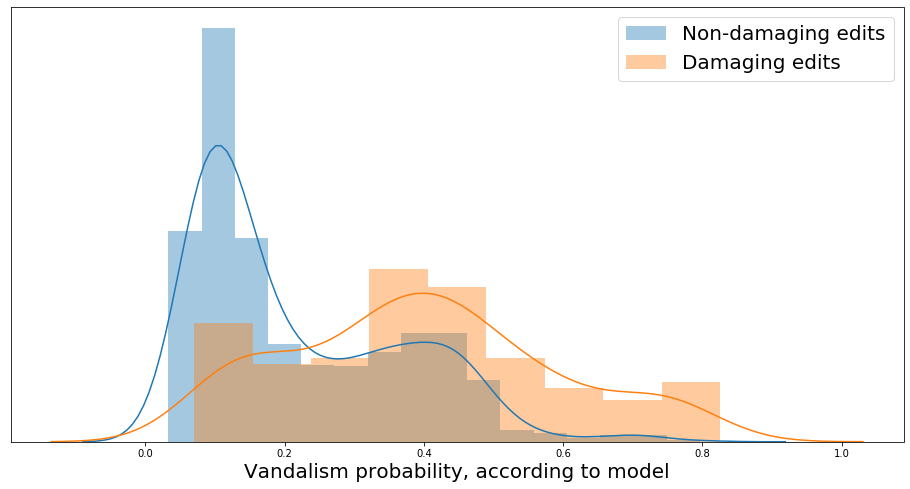

In [819]:
proba_plot(gb, X_test, y_test)

And now let's run our model using the human-labeled data as a final validation set.

In [812]:
X_labeled = labeled_ores[['badwords', 'fromsize', 'added_bytes', 'deleted_bytes',
              'country_damage', 'culture', 'geography', 'hist_soc', 'stem']]
y_labeled = labeled_ores['damaging'].map(int)

# scaler = StandardScaler()
# X_lab_scaled = scaler.fit_transform(X_labeled)

y_pred = gb.predict(X_labeled)
print("Accuracy score:", accuracy_score(y_labeled, y_pred))
print("F1 score:", f1_score(y_labeled, y_pred))
print("ROC AUC score:", roc_auc_score(y_labeled, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_labeled, y_pred))

Accuracy score: 0.8497109826589595
F1 score: 0.31578947368421056
ROC AUC score: 0.5964398684589896
Confusion matrix:
 [[2538  127]
 [ 341  108]]


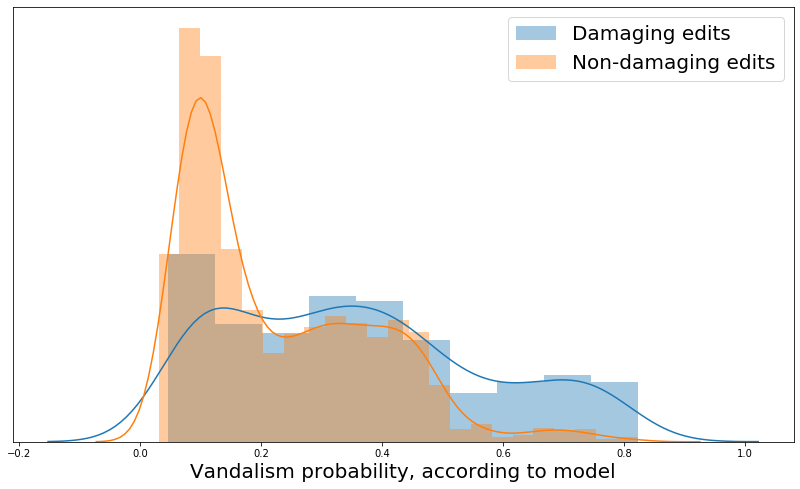

In [813]:
proba_plot(gb, X_labeled, y_labeled)